In [135]:
!nvidia-smi

Tue Mar  7 11:15:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.50       Driver Version: 472.50       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| 44%   67C    P2   122W / 320W |   8595MiB / 10240MiB |     35%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Settings

In [136]:
# 필요 모델 호출
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import math
import time
import random
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim

In [137]:
def seed_everything(seed: int = 2022):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [138]:
class config:
    seed = 2022

In [139]:
seed_everything(config.seed)
# seed = 2022
# tf.random.set_seed(seed)

# Load Dataset

In [140]:
# 이미지 로드
imglist = os.listdir('/Users/User/303/COVID-19_Radiography_Dataset/COVID/images/')
def load_image(path):
    image_list = np.zeros((len(imglist), 128, 128))
    for i in range(len(imglist)):
        img = Image.open('/Users/User/303/COVID-19_Radiography_Dataset/COVID/images/'+str(imglist[i])).convert('L')
        image_list[i] = img
    return image_list

In [141]:
posi = load_image('/Users/User/303/COVID-19_Radiography_Dataset/COID/images/*.png')
posi = posi.astype('float32')/255.
print(posi.shape)

(3616, 128, 128)


# Train Validation Test Split

In [142]:
from sklearn.model_selection import train_test_split

X_trainval, x_test = train_test_split(posi, test_size=0.2, random_state=42)
x_train, x_val = train_test_split(X_trainval, train_size=0.75, random_state=42)

In [143]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(2169, 128, 128)
(723, 128, 128)
(724, 128, 128)


In [144]:
# def train_test_split(img):
#     rnd = np.random.RandomState(seed=51)
#     perm = rnd.permutation(len(img))
#     train_idx = perm[:int(0.8 * len(img))]
#     test_idx = perm[int(0.8 * len(img)):]
#     return img[train_idx], img[test_idx]

# x_train, x_test = train_test_split(posi)
# print(x_train.shape, x_test.shape)

# Noise

In [145]:
def noisy(noise_typ,image):
    #Gaussian Noisy
    if noise_typ == "gauss":
        
        noisy = image + 0.1 *  np.random.normal(loc=0,scale=1.,size=image.shape)
        return noisy
    #Salt & Pepper Noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.05
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[tuple(coords)] = 1
        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[tuple(coords)] = 0
        return out

    # Speckle Noisy
    elif noise_typ =="speckle":
        noisy = np.random.normal(loc=0,scale=1.,size=image.shape)
        noisy = image+ image * 0.1 *noisy
        return noisy
    # Poisson Noisy
    elif noise_typ == "poisson":
        
        noisy = image + 0.1 *  np.random.poisson(lam=1.0,size=image.shape)
        return noisy

In [146]:
def MAE(img1, img2):
    D = np.array(img1 - img2, dtype=np.float64)
    D[:, :] = np.abs(D[:, :])
    MAE = D.sum()/img1.size
    return MAE

def PSNR(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [147]:
from skimage.restoration import denoise_nl_means, denoise_bilateral
from scipy.signal import medfilt2d
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from skimage.util import random_noise

def Meanfilter(noisy_test_data):
    meanfilter = []
    for i in range(len(noisy_test_data)):
         meanfilter.append(cv2.blur(noisy_test_data[i],(3,3)))
    meanfilter = np.array(meanfilter)
    return meanfilter
    
def Medianfilter(noisy_test_data):
    medianfilter = []
    for i in range(len(noisy_test_data)):
        medianfilter.append(medfilt2d(noisy_test_data[i],(3,3)))
    medianfilter = np.array(medianfilter)
    return medianfilter


def lee_filter(img):
    lee = []
    for i in range(len(img)):
        img_mean = uniform_filter(img[i])
        img_sqr_mean = uniform_filter(img[i]**2)
        img_variance = img_sqr_mean - img_mean**2
        
        overall_variance = variance(img[i])
        
        img_weights = (img_variance**2) / ((img_variance**2) + (overall_variance**2))
        img_output = img_mean + img_weights * (img[i] - img_mean)
        
        lee.append(img_output)
    lee = np.array(lee)
    return lee

In [148]:
# Add Noisy
x_train_sp_noisy = noisy("gauss",x_train)
x_val_sp_noisy = noisy("gauss",x_val)

x_test_sp_noisy = noisy("gauss",x_test)

x_train_sp_noisy=x_train_sp_noisy.clip(0,1)
x_val_sp_noisy=x_val_sp_noisy.clip(0,1)

x_test_sp_noisy=x_test_sp_noisy.clip(0,1)
x_train_sp_noisy[0]

array([[0.03524133, 0.        , 0.00960086, ..., 0.        , 0.        ,
        0.25569832],
       [0.18966787, 0.        , 0.16422461, ..., 0.01901354, 0.06006142,
        0.08837302],
       [0.        , 0.        , 0.01300827, ..., 0.00696893, 0.        ,
        0.03027531],
       ...,
       [0.        , 0.        , 0.04523663, ..., 0.11358681, 0.17416708,
        0.        ],
       [0.        , 0.15981305, 0.        , ..., 0.02382187, 0.        ,
        0.03555864],
       [0.        , 0.12773165, 0.0765071 , ..., 0.08724136, 0.04675634,
        0.        ]])

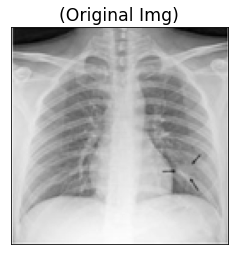

In [165]:
# Original Image
ax = plt.subplot()
plt.imshow(x_test[21], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("(Original Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

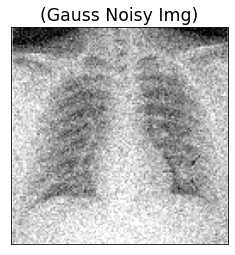

In [166]:
# Salt & Pepper Noisy Image
ax = plt.subplot()
plt.imshow(x_test_sp_noisy[21], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("(Gauss Noisy Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

CPU 시간 : 0.09372997283935547


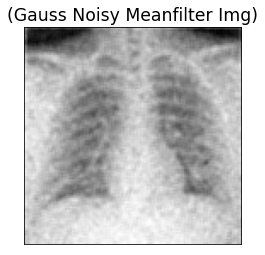

In [167]:
# MeanFilter Image
start = time.time()
mean_x_test_sp_noisy = Meanfilter(x_test_sp_noisy)
end = time.time()
Meantime= end - start
print("CPU 시간 : "+str(Meantime))

ax = plt.subplot()
plt.imshow(mean_x_test_sp_noisy[21], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title("(Gauss Noisy Meanfilter Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

CPU 시간 : 1.1247620582580566


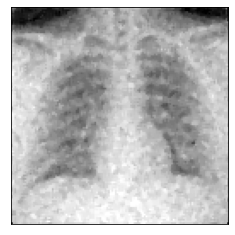

In [168]:
# MedianFilter Image
start = time.time()
median_x_test_sp_noisy = Medianfilter(x_test_sp_noisy)
end = time.time()
Mediantime= end - start
print("CPU 시간 : "+str(Mediantime))

ax = plt.subplot()
plt.imshow(median_x_test_sp_noisy[21], cmap=plt.cm.gray)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)


In [153]:
bilateral_x_test_sp_noisy=[]
for i in range(len(x_test_sp_noisy)):
    #img=denoise_bilateral(x_test_sp_noisy[i], sigma_spatial=.5)
    src =x_test_sp_noisy[i]
    src =np.array(src)
    src =np.float32(src)
    #26
    img=cv2.bilateralFilter(src, d=-1, sigmaColor=0.23, sigmaSpace=2)
    
    bilateral_x_test_sp_noisy= np.append(bilateral_x_test_sp_noisy,img)
    bilateral_x_test_sp_noisy =np.array(bilateral_x_test_sp_noisy)

bilateral_x_test_sp_noisy = bilateral_x_test_sp_noisy.reshape(len(x_test_sp_noisy),128,128)
bilateral_x_test_sp_noisy = bilateral_x_test_sp_noisy.clip(0,1)
bilateral_x_test_sp_noisy =bilateral_x_test_sp_noisy.astype('float32')
print(bilateral_x_test_sp_noisy.shape)


(724, 128, 128)


In [154]:
# src =x_test_sp_noisy[1]
# src =np.array(src)
# src =np.float32(src)
# img=cv2.bilateralFilter(src, d=-1, sigmaColor=0.23, sigmaSpace=2)
# plt.imshow(img,cmap='gray')
# plt.title("(Gauss Noisy Bilateral Filter Img)", position=(0.5,-0.12),fontsize = "xx-large")
# print(PSNR(img,x_test[1]))
# print(ssim(img,x_test[1]))
# plt.show()

28.13238263224322
0.8681791468001091


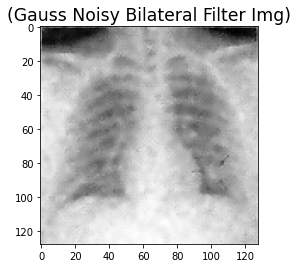

In [170]:
plt.imshow(bilateral_x_test_sp_noisy[21],cmap='gray')
plt.title("(Gauss Noisy Bilateral Filter Img)", position=(0.5,-0.12),fontsize = "xx-large")
print(PSNR(bilateral_x_test_sp_noisy[21],x_test[21]))
print(ssim(bilateral_x_test_sp_noisy[21],x_test[21]))
plt.show()

In [156]:
nlmeans_x_test_sp_noisy=[]
#5 ,3, 0.1 ->psnr30
for i in range(len(x_test_sp_noisy)):
    #img=denoise_nl_means(x_test_sp_noisy[i], patch_size = 9, patch_distance =25, h = 0.1, fast_mode=False ,sigma =0.0 )
    #src =x_test_sp_noisy[i]
    #src = (src * 255).astype('uint8')
    img=denoise_nl_means(x_test_sp_noisy[i], patch_size = 9, patch_distance =9, h = 0.1, fast_mode=False ,sigma =0.0 )
    #img=denoise_nl_means(x_test_sp_noisy[i], patch_size = 9, patch_distance =13, h = 0.1, fast_mode=False ,sigma =0.0 )
    #img = img.astype('float32')/255.
    nlmeans_x_test_sp_noisy= np.append(nlmeans_x_test_sp_noisy,img)
    nlmeans_x_test_sp_noisy =np.array(nlmeans_x_test_sp_noisy)

nlmeans_x_test_sp_noisy = nlmeans_x_test_sp_noisy.reshape(len(x_test_sp_noisy),128,128)
nlmeans_x_test_sp_noisy= nlmeans_x_test_sp_noisy.clip(0,1)
nlmeans_x_test_sp_noisy =nlmeans_x_test_sp_noisy.astype('float32')
print(nlmeans_x_test_sp_noisy.shape)

(724, 128, 128)


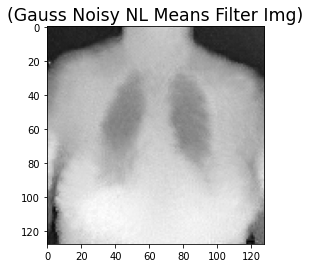

In [157]:
plt.imshow(nlmeans_x_test_sp_noisy[1],cmap='gray')
plt.title("(Gauss Noisy NL Means Filter Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()

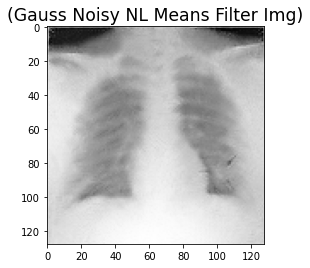

28.404358250644325
0.8742388502151681


C:\Users\User\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


In [171]:
img=denoise_nl_means(x_test_sp_noisy[21], patch_size = 9, patch_distance =9, h = 0.1, fast_mode=False ,sigma =0.0 )
plt.imshow(nlmeans_x_test_sp_noisy[21],cmap='gray')
plt.title("(Gauss Noisy NL Means Filter Img)", position=(0.5,-0.12),fontsize = "xx-large")
plt.show()
print(PSNR(img,x_test[21]))
print(ssim(img,x_test[21]))

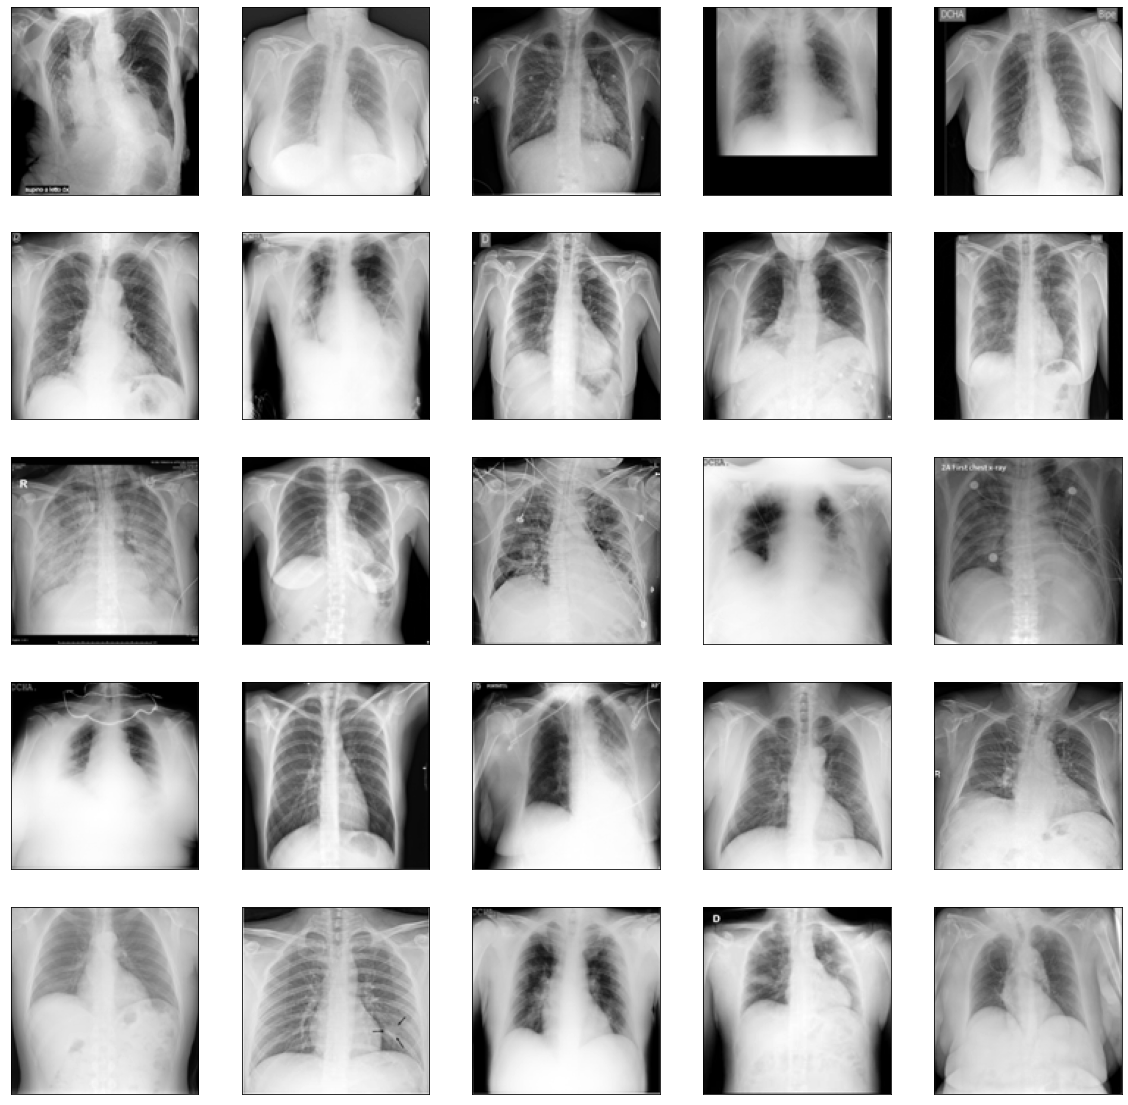

In [159]:
# 5x5 서브플롯 생성
fig, axs = plt.subplots(5, 5, figsize=(20, 20))

# 각 서브플롯에 이미지 출력
for i, ax in enumerate(axs.flat):
    ax.imshow(x_test[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

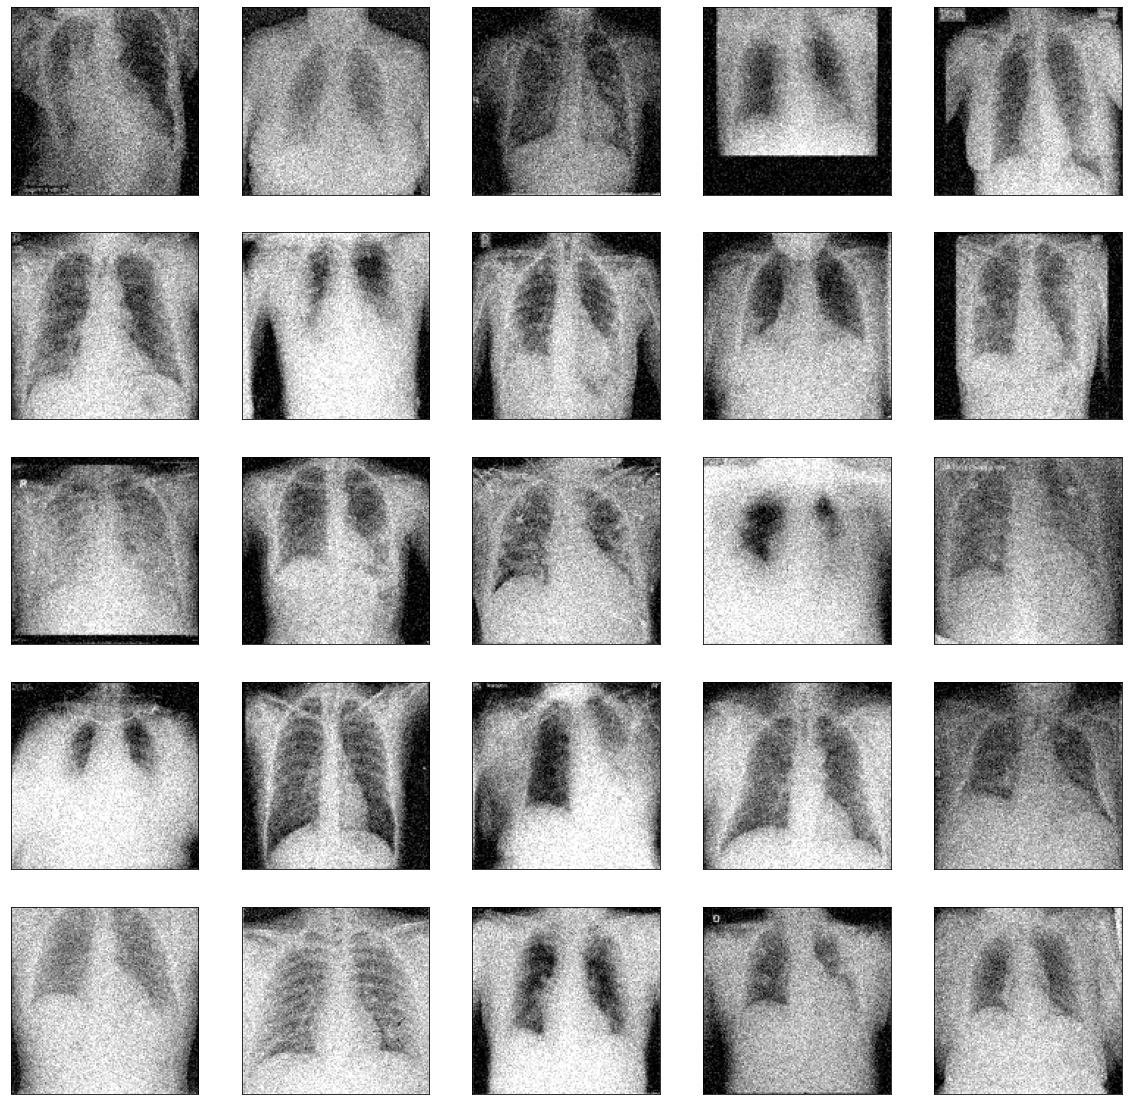

In [164]:
# 5x5 서브플롯 생성
fig, axs = plt.subplots(5, 5, figsize=(20, 20))

# 각 서브플롯에 이미지 출력
for i, ax in enumerate(axs.flat):
    ax.imshow(x_test_sp_noisy[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

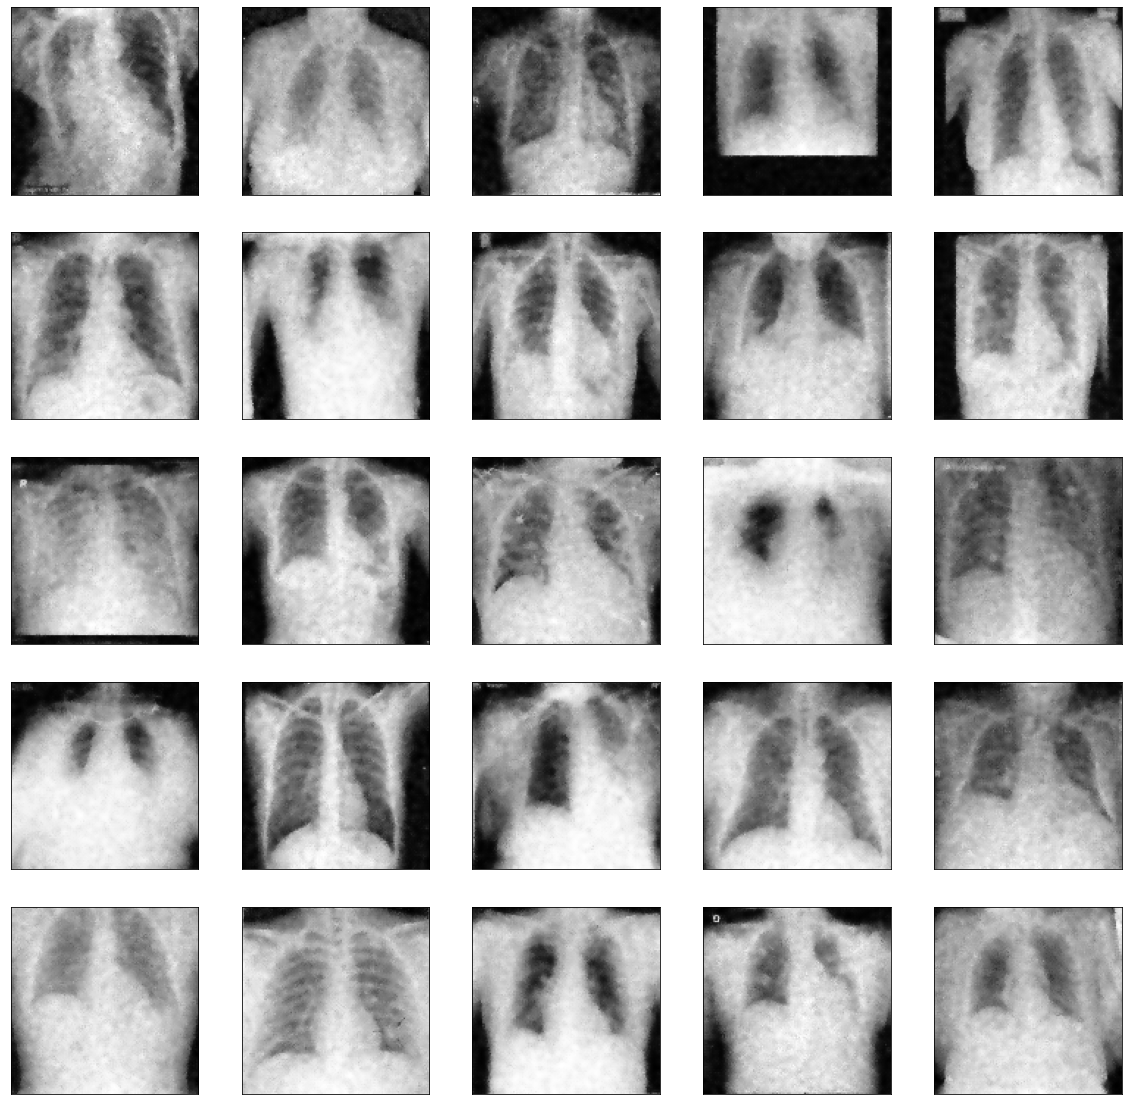

In [160]:
# 5x5 서브플롯 생성
fig, axs = plt.subplots(5, 5, figsize=(20, 20))

# 각 서브플롯에 이미지 출력
for i, ax in enumerate(axs.flat):
    ax.imshow(bilateral_x_test_sp_noisy[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

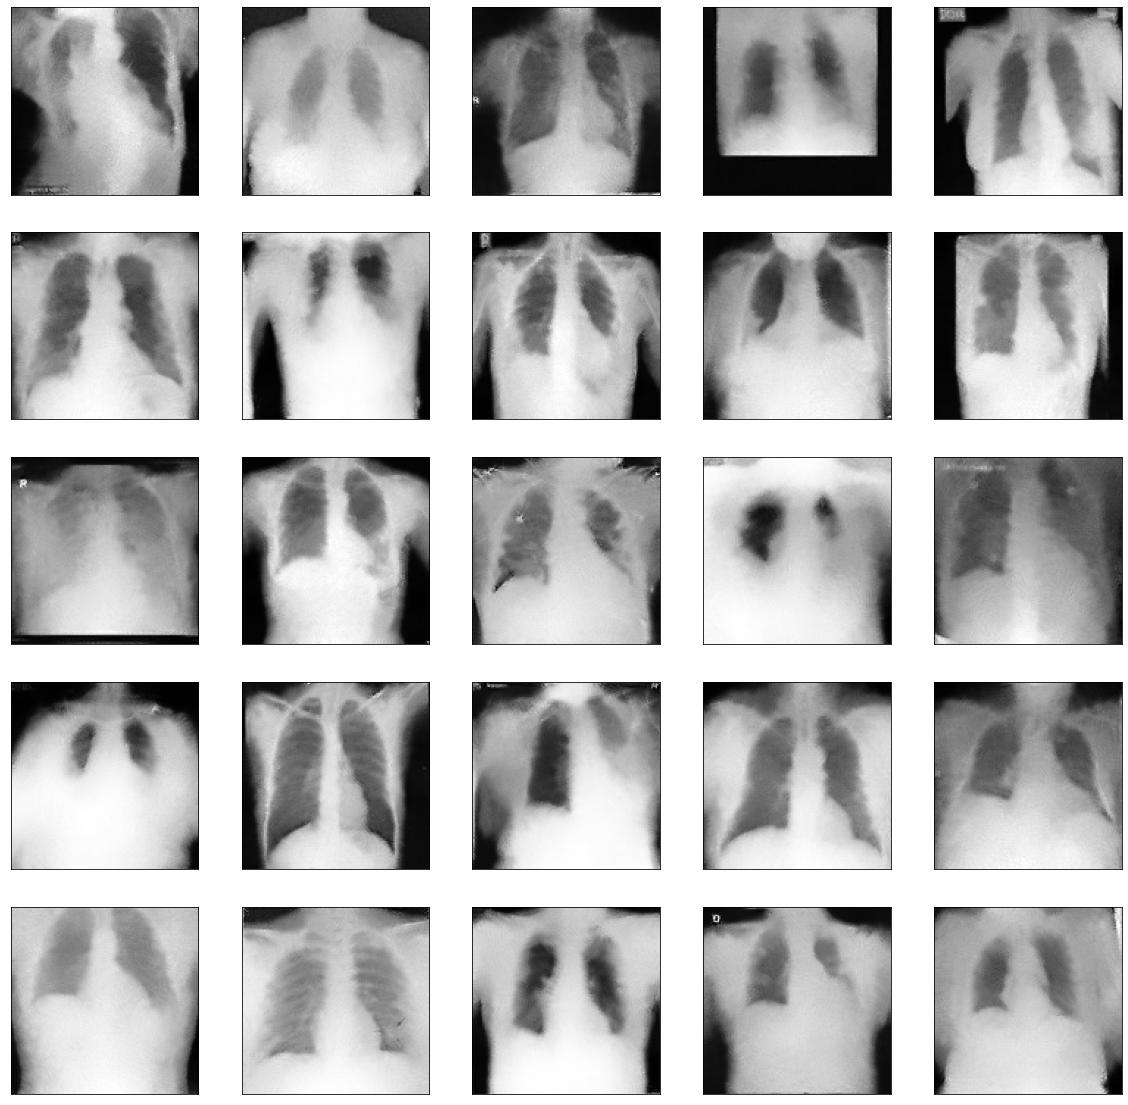

In [161]:
# 5x5 서브플롯 생성
fig, axs = plt.subplots(5, 5, figsize=(20, 20))

# 각 서브플롯에 이미지 출력
for i, ax in enumerate(axs.flat):
    ax.imshow(nlmeans_x_test_sp_noisy[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [162]:
psnr_mean = []
mae_mean = []
psnr_median = []
mae_median = []
psnr_nlmeans = []
mae_nlmeans = []
psnr_bilateral = []
mae_bilateral = []

ssim_mean=[]
ssim_median=[]
ssim_nlmeans=[]
ssim_bilateral=[]

for i in range(len(x_test_sp_noisy)):
    mae_mean.append(MAE(mean_x_test_sp_noisy[i],x_test[i]))
    mae_median.append(MAE(median_x_test_sp_noisy[i],x_test[i]))
    mae_nlmeans.append(MAE(nlmeans_x_test_sp_noisy[i],x_test[i]))
    mae_bilateral.append(MAE(bilateral_x_test_sp_noisy[i],x_test[i]))  
    
    psnr_mean.append(PSNR(mean_x_test_sp_noisy[i],x_test[i]))
    psnr_median.append(PSNR(median_x_test_sp_noisy[i],x_test[i]))
    psnr_nlmeans.append(PSNR(nlmeans_x_test_sp_noisy[i],x_test[i]))
    psnr_bilateral.append(PSNR(bilateral_x_test_sp_noisy[i],x_test[i]))
    
    ssim_mean.append(ssim(x_test[i], mean_x_test_sp_noisy[i]))
    ssim_median.append(ssim(x_test[i], median_x_test_sp_noisy[i]))
    ssim_nlmeans.append(ssim(x_test[i], nlmeans_x_test_sp_noisy[i]))
    ssim_bilateral.append(ssim(x_test[i], bilateral_x_test_sp_noisy[i]))
    

In [163]:
print("About Gauss Noisy")
print("Mean Filter : MAE = " +  str(np.mean(mae_mean)) + " & PSNR = " + str(np.mean(psnr_mean))+" & SSIM = "+str(np.mean(ssim_mean)))
print("Median Filter : MAE = " +  str(np.mean(mae_median)) + " & PSNR = " + str(np.mean(psnr_median))+" & SSIM = "+str(np.mean(ssim_median)))
print("Bilateral Filter : MAE = " +  str(np.mean(mae_bilateral)) + " & PSNR = " + str(np.mean(psnr_bilateral))+" & SSIM = "+str(np.mean(ssim_bilateral)))
print("NL Means Filter : MAE = " +  str(np.mean(mae_nlmeans)) + " & PSNR = " + str(np.mean(psnr_nlmeans))+" & SSIM = "+str(np.mean(ssim_nlmeans)))
#print("De_CAE Filter : MAE = " +  str(np.mean(mae_cae)) + " & PSNR = " + str(np.mean(psnr_cae))+" & SSIM = "+str(np.mean(ssim_cae)))


About Gauss Noisy
Mean Filter : MAE = 0.03037000065560521 & PSNR = 28.11556948367694 & SSIM = 0.8408436405800095
Median Filter : MAE = 0.035166092821897005 & PSNR = 26.66803531666919 & SSIM = 0.79193672652751
Bilateral Filter : MAE = 0.027255649404385084 & PSNR = 29.1461760896614 & SSIM = 0.8693281236327159
NL Means Filter : MAE = 0.02540361226664172 & PSNR = 29.741095043356 & SSIM = 0.8952490258747443
